# Finding the Centers of the Ellipses

We include all the required libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

## Image Loading

In [23]:
# We get the path to the current script
baseFolder = os.getcwd()
folder = os.path.join(baseFolder, "photos", "diffDefect")

# We load the image
img = cv.imread(os.path.join(folder, "logo_cropped.png"), 0)

## Finding Ellipses

In [24]:
def formCenter(image):
    """"
    This function returns the center of the form in the image,
    for the scope of this project ellipses
    """

    # We start by detecting the edges in the image for this purpose we use the canny method
    blur = cv.GaussianBlur(image, (11 , 11), 1)

    # We find the center of the ellipse in the closed image
    whiteCenter, max_contour1, whiteEllipse = findEllipseCenter(blur)

    # We colour the found ellipse contour in white color to make it unvisible for the next step
    border_mask = np.zeros_like(image)
    cv.drawContours(border_mask, [max_contour1], -1, 255, thickness=1)

    # We create a mask for the logo, which is the area inside the ellipse
    logo_mask = np.zeros_like(image)
    cv.drawContours(logo_mask, [max_contour1], -1, 255, thickness=cv.FILLED)

    # We apply the masks to a copy of the original image
    masked_image = image.copy()

    # We make all the surrounding area of the logo white
    masked_image[border_mask == 255] = 255
    masked_image[logo_mask == 0] = 255

    # We threshold the masked image to create a binary image
    _, thBinary = cv.threshold(masked_image, 200, 255, cv.THRESH_BINARY)

    # We find the center of the ellipse in the binary image
    colorCenter, max_contour2, colorEllipse = findEllipseCenter(thBinary)

    img_Result = image.copy()
    # We make this a color image
    img_Result = cv.cvtColor(img_Result, cv.COLOR_GRAY2BGR)
    # We draw the white ellipse contour and center in green
    cv.ellipse(img_Result, whiteEllipse, (0, 255, 0), 2)
    cv.circle(img_Result, whiteCenter, 5, (0, 255, 0),  -1)
    # We draw the color ellipse contour and center in Blue
    cv.ellipse(img_Result, colorEllipse, (255, 0, 0), 2)
    cv.circle(img_Result, colorCenter, 5, (255, 0, 0), -1)

    return whiteCenter, colorCenter, whiteEllipse, colorEllipse, img_Result


def findEllipseCenter(image):
    # We start by detecting the edges in the image for this purpose we use the canny method
    edges = cv.Canny(image, 50, 150, L2gradient=True)

    # We close the edges, by creating an elliptical kernel that we will use to close the edges
    # This will connect the edges that are close to each other
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (7, 7))
    closed = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)

    # We start by finding the contours in the image
    contours, _ = cv.findContours(closed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Then, we are going to select the largest contour in terms of area
    max_contour = max(contours, key=cv.contourArea)

    # We are going to fit an ellipse to the largest contour
    ellipse = cv.fitEllipse(max_contour)

    # we get the center of the ellipse
    center = (int(ellipse[0][0]), int(ellipse[0][1]))

    return center, max_contour, ellipse

def textCenter(image):

    # We start by thresholding the image to keep only the text
    _, thBinary = cv.threshold(img, 120, 255, cv.THRESH_BINARY)

    # We detect the edges using Canny
    low_thresh  = 50
    high_thresh = 150
    edges_masked = cv.Canny(thBinary, low_thresh, high_thresh, apertureSize=3)

    # We create a mask to keep only the text area
    contours_masked, _ = cv.findContours(edges_masked, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # We crete a copy of the binary image to draw the contours
    contour_vis = cv.cvtColor(thBinary, cv.COLOR_GRAY2BGR)

    # Minimum perimeter to consider a contour
    minimum_Perimeter = 50  # This value can be adjusted!

    rect_x_izq = 10000
    rect_x_der = 0
    rect_y_up = 10000
    rect_y_down = 0

    # We only consider contours with a perimeter larger than the minimum, to rull out noise
    for contour in contours_masked:
        perimeter = cv.arcLength(contour, True)
        if perimeter > minimum_Perimeter:

            # We extract the coordinates
            points = contour[:, 0, :]

            cv.drawContours(contour_vis, [contour], -1, (0, 255, 0), 2)

            # Extreme coordinates of the contour
            x_left = points[:, 0].min()
            x_rigth = points[:, 0].max()
            y_up = points[:, 1].min()
            y_down = points[:, 1].max()

            # We update the rectangle coordinates that bounds the text
            rect_x_izq = min(rect_x_izq, x_left)
            rect_x_der = max(rect_x_der, x_rigth)
            rect_y_up = min(rect_y_up, y_up)
            rect_y_down = max(rect_y_down, y_down)

    # We find the center of the rectangle that bounds the text
    center = ((rect_x_izq + rect_x_der) // 2, (rect_y_up + rect_y_down) // 2)

    # We draw the rectangle and the circle in the image
    cv.rectangle(contour_vis, (rect_x_izq, rect_y_up), (rect_x_der, rect_y_down), (0, 0, 255), 2)
    cv.circle(contour_vis, center, 4, (0, 0, 255), -1)

    return center, contour_vis


(np.float64(-0.5), np.float64(391.5), np.float64(280.5), np.float64(-0.5))

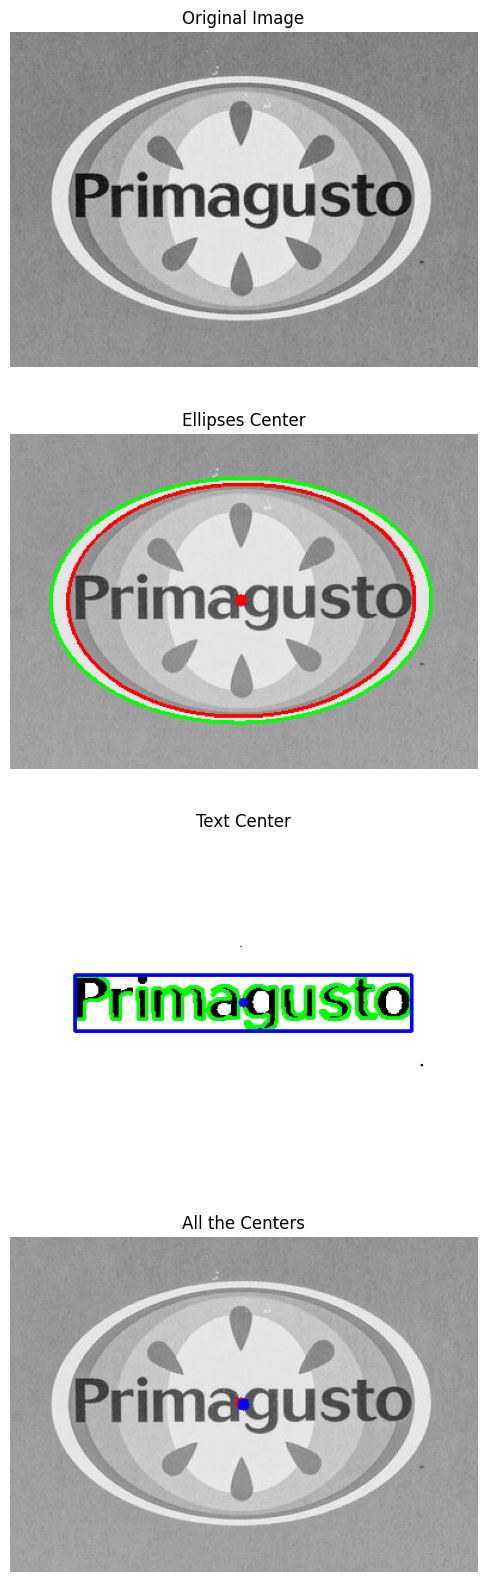

In [26]:
whiteCenter, colorCenter, whiteEllipse, colorEllipse, img_Result = formCenter(img)
text_Center, img_Text = textCenter(img)

# We create a color image to place all the centers
img_show = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
# We draw the centers of the ellipses and text in the image
cv.circle(img_show, whiteCenter, 5, (0, 255, 0), -1) # Green for white ellipse center
cv.circle(img_show, colorCenter, 5, (255, 0, 0), -1) # Blue for color ellipse center
cv.circle(img_show, text_Center, 5, (0, 0, 255), -1) # Red for text center

# We show the results
plt.figure(figsize=(20, 20))
plt.subplot(4, 1, 1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(4, 1, 2)
plt.imshow(img_Result)
plt.title("Ellipses Center")
plt.axis('off')
plt.subplot(4, 1, 3)
plt.imshow(img_Text)
plt.title("Text Center")
plt.axis('off')
plt.subplot(4, 1, 4)
plt.imshow(img_show)
plt.title("All the Centers")
plt.axis('off')